In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...

Updating files:  20% (503/2451)

Updating files:  21% (515/2451)

Updating files:  22% (540/2451)

Updating files:  23% (564/2451)

Updating files:  24% (589/2451)

Updating files:  25% (613/2451)

Updating files:  26% (638/2451)

Updating files:  27% (662/2451)

Updating files:  28% (687/2451)

Updating files:  29% (711/2451)

Updating files:  30% (736/2451)

Updating files:  31% (760/2451)

Updating files:  32% (785/2451)

Updating files:  33% (809/2451)

Updating files:  34% (834/2451)

Updating files:  35% (858/2451)

Updating files:  35% (870/2451)

Updating files:  36% (883/2451)

Updating files:  37% (907/2451)

Updating files:  38% (932/2451)

Updating files:  39% (956/2451)

Updating files:  40% (981/2451)

Updating files:  41% (1005/2451)

Updating files:  42% (1030/2451)

Updating files:  43% (1054/2451)

Updating files:  43% (1073/2451)

Updating files:  44% (1079/2451)

Updating files:  45% (1103/2451)

Updating files:  46% (1128/2451)

Updating f

In [7]:
pwd

'C:\\Users\\Mohit Bansal'

In [8]:
cd models

C:\Users\Mohit Bansal\models


In [9]:
cd research

C:\Users\Mohit Bansal\models\research


In [12]:
protoc --python_out=. .\object_detection\protos\anchor_generator.proto .\object_detection\protos\argmax_matcher.proto .\object_detection\protos\bipartite_matcher.proto .\object_detection\protos\box_coder.proto .\object_detection\protos\box_predictor.proto .\object_detection\protos\eval.proto .\object_detection\protos\faster_rcnn.proto .\object_detection\protos\faster_rcnn_box_coder.proto .\object_detection\protos\grid_anchor_generator.proto .\object_detection\protos\hyperparams.proto .\object_detection\protos\image_resizer.proto .\object_detection\protos\input_reader.proto .\object_detection\protos\losses.proto .\object_detection\protos\matcher.proto .\object_detection\protos\mean_stddev_box_coder.proto .\object_detection\protos\model.proto .\object_detection\protos\optimizer.proto .\object_detection\protos\pipeline.proto .\object_detection\protos\post_processing.proto .\object_detection\protos\preprocessor.proto .\object_detection\protos\region_similarity_calculator.proto .\object_detection\protos\square_box_coder.proto .\object_detection\protos\ssd.proto .\object_detection\protos\ssd_anchor_generator.proto .\object_detection\protos\string_int_label_map.proto .\object_detection\protos\train.proto .\object_detection\protos\keypoint_box_coder.proto .\object_detection\protos\multiscale_anchor_generator.proto .\object_detection\protos\graph_rewriter.proto .\object_detection\protos\calibration.proto .\object_detection\protos\flexible_grid_anchor_generator.proto

Invalid file name pattern or missing input file "Bansal/models/research/object_detection/protos/*.proto'"


In [ ]:
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [1]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [3]:
labelmap_path = 'C:/Users/Varsha Dhare/Downloads/labelmap.pbtxt'

In [4]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [ ]:
tf.keras.backend.clear_session()
model = tf.saved_model.load('C:/Users/Varsha Dhare/Downloads/inference_graph-20210531T064818Z-001/inference_graph/saved_model')

In [6]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

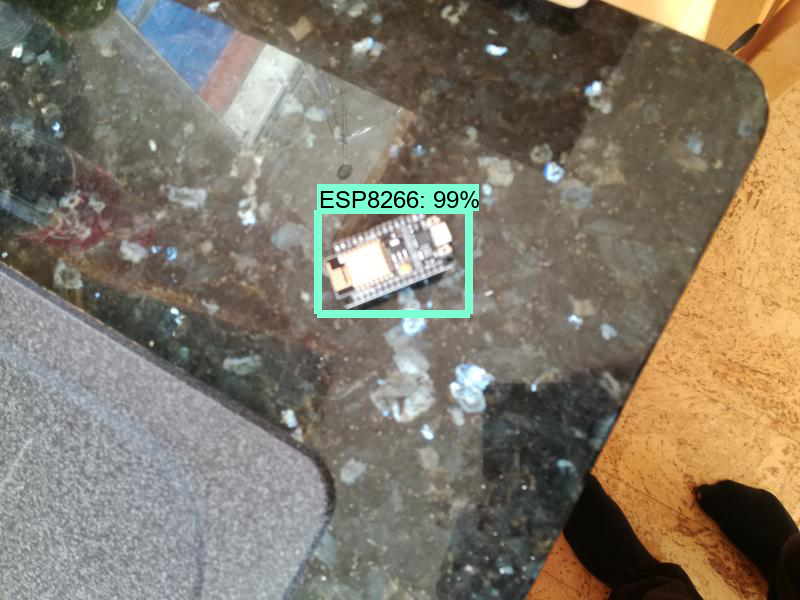

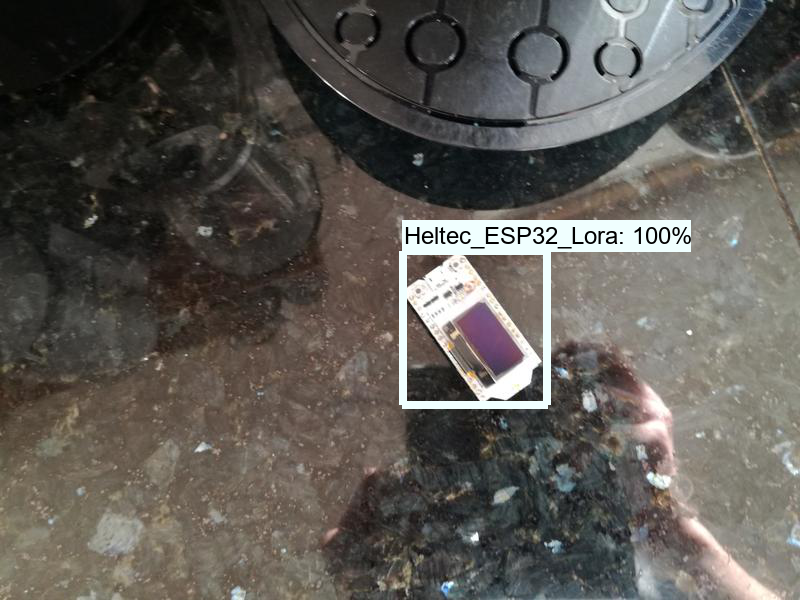

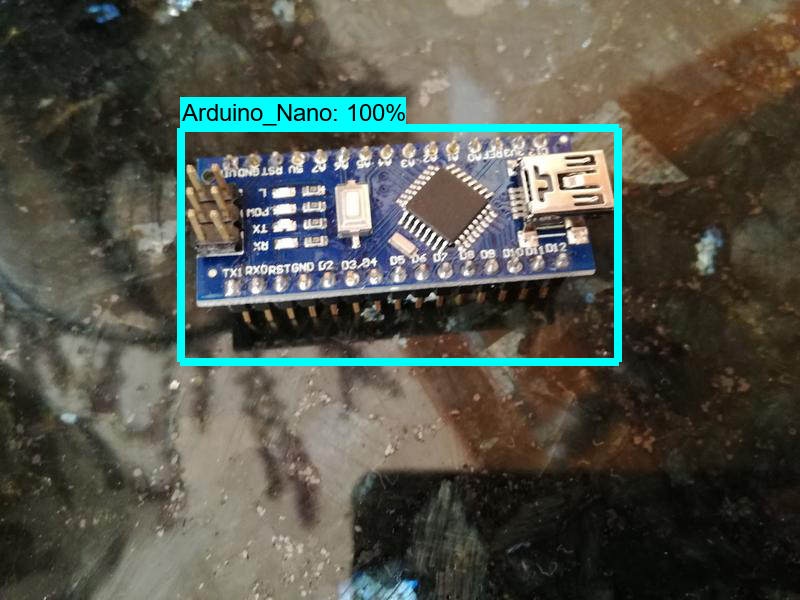

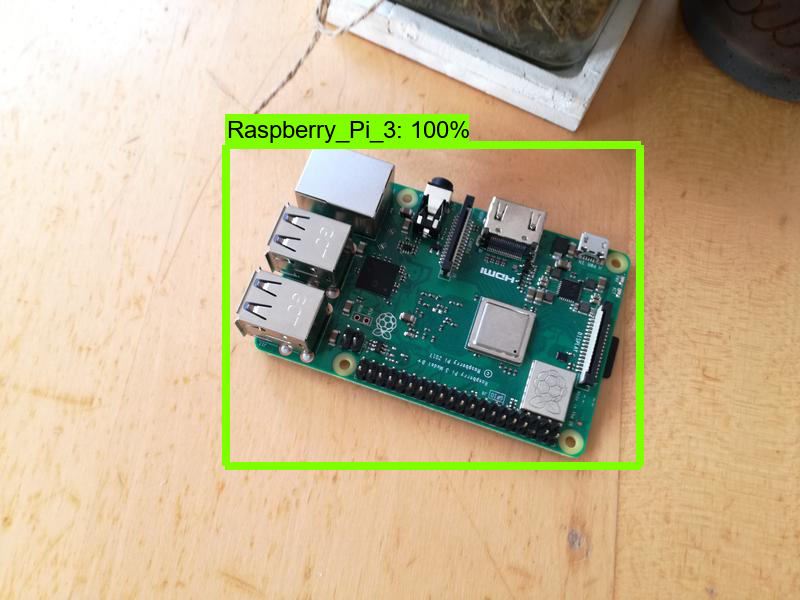

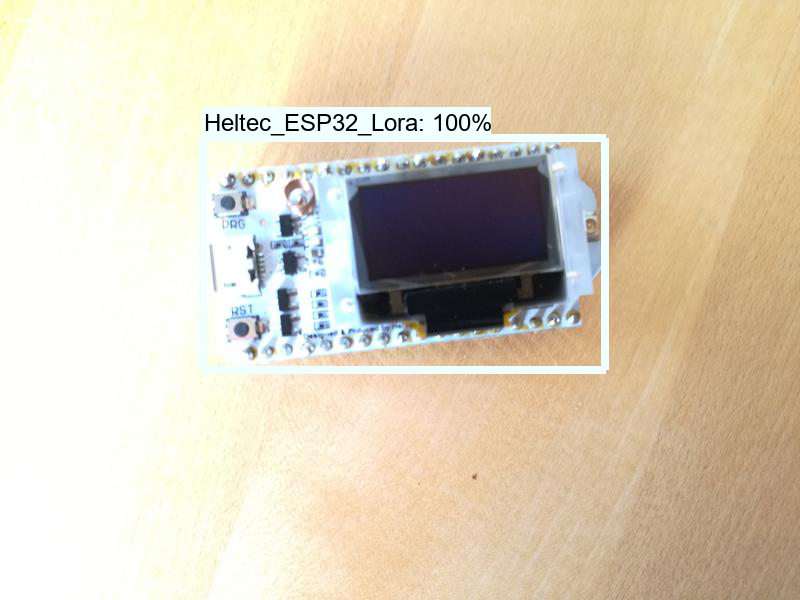

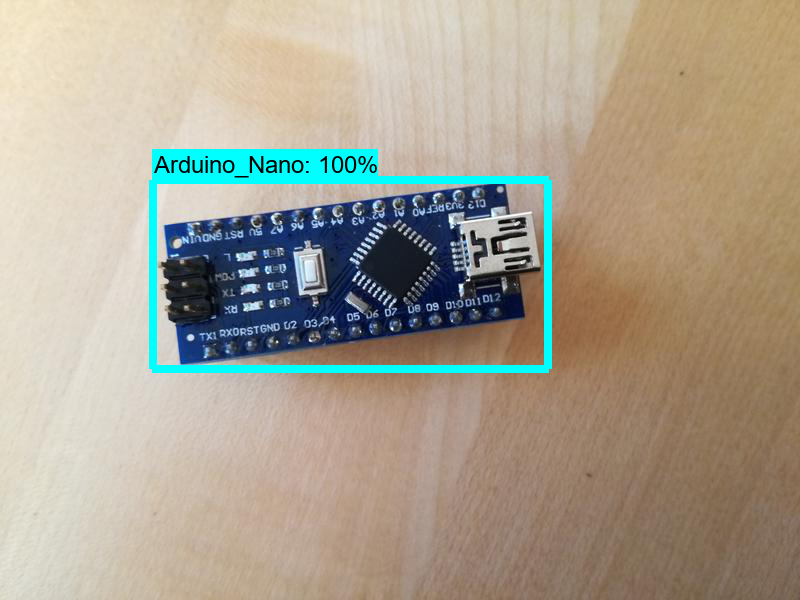

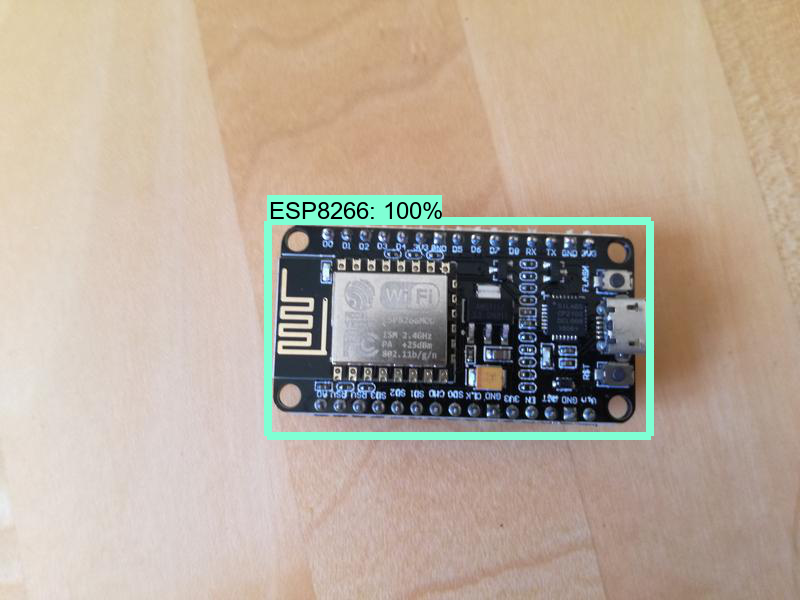

In [7]:
for image_path in glob.glob('C:/Users/Varsha Dhare/Desktop/test/*.jpg'):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  display(Image.fromarray(image_np))

In [21]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sys

In [22]:
video = cv2.VideoCapture(0)
ret = video.set(3,640)
ret = video.set(4,480)


In [23]:
result=cv2.VideoWriter('filename.mp4',cv2.VideoWriter_fourcc(*'MP4V'),10,(640,480))

In [24]:
while(True):

    # Acquire frame and expand frame dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    ret, frame_rgb = video.read()
    print(frame_rgb)
    output_dict = run_inference_for_single_image(model, frame_rgb)
    vis_util.visualize_boxes_and_labels_on_image_array(
          frame_rgb,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks_reframed', None),
          use_normalized_coordinates=True,
          line_thickness=8)
    result.write(frame_rgb)
    cv2.imshow('Object detector', frame_rgb)

    # Press 'q' to quit
    if cv2.waitKey(1) == ord('q'):
        break
video.release()
result.release()
cv2.destroyAllWindows()

[[[21  6 46]
  [21  6 46]
  [13  7 46]
  ...
  [53 30 46]
  [58 26 43]
  [58 26 43]]

 [[21  6 46]
  [21  6 46]
  [14  6 41]
  ...
  [50 30 43]
  [52 29 43]
  [52 29 43]]

 [[22  5 43]
  [23  6 44]
  [14  7 40]
  ...
  [48 34 44]
  [49 32 43]
  [49 32 43]]

 ...

 [[36  9 25]
  [37 10 26]
  [37 12 26]
  ...
  [61 38 42]
  [61 40 44]
  [62 41 45]]

 [[37 10 26]
  [38 11 27]
  [39 13 25]
  ...
  [63 37 41]
  [63 40 43]
  [64 41 44]]

 [[37 10 24]
  [38 11 25]
  [39 13 25]
  ...
  [66 36 37]
  [61 39 38]
  [63 41 40]]]


error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-4g0fenxj\opencv\modules\highgui\src\window.cpp:679: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
